# Analysis of pediatric appendicitis from Regensburg, Germany
## DTSA-5509 Intro to Machine Learning Final Project
## Description of the data and source: 
According to the data description on Kaggle this dataset "was acquired in a retrospective study from a cohort of pediatric patients admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany."  The original dataset included ultrasound images but the portion of the dataset used here includes data "encompassing laboratory tests, physical examination results, clinical scores, such as Alvarado and pediatric appendicitis scores."  
## Project goal
The goal of this project is to determine if the laboratory tests, physical exam, and clinical scores provide enough information to predict the diagnosis.  The task is classification using the Diagnosis field as the target variable.  The Diagnosis is "appendicitis" or "no appendicitis".
## Source of the data: 
The data can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/joebeachcapital/regensburg-pediatric-appendicitis)

## Exploratory Data Analysis
### Initial Inspection
The csv filesize is 186kB.  There are 68 columns when initially pulling the data into a data frame but the last ten invalid.  The dataset has 55 features, 3 targets, and 782 samples.  Each sample is an individual patient.  There is a mix of numerical values and categorical values and many of the categorical fields are simple yes / no values.  Each sample contains basic information about the patient including age, BMI, sex, height, and weight.  Additionally, there are clinical diagnostics such as appendix diameter, pain assessments, body temperature, and red and white blood cell counts.
### Cleaning and Culling
- The columns in the right-half of the data frame are very sparse so they were removed entirely.
- The BMI and Height columns were removed since they have a high correlation to the Weight
- Several clinical diagnostic features were removed simply to reduce the overall number of features
- The Length_of_Stay column was removed because it was filled in at time of patient discharge so it doesn't make sense for it to be used in predicting the diagnosis.
- The Segmented_Neutrophils column was removed because it was largely empty.
- Many rows were missing a value for one of the remaining features so they were removed.  Since each row is an individual patient, it wasn't obvious how to impute values, though an approach could have been to impute the average for the column.
- The Appendix_Diameter was considered for removal because it has over 250 null entries.  However, model performance with Appendix_Diameter included was considerably better than with it removed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.pyplot import subplots
#import statsmodels.api as sm
#from ISLP.models import ModelSpec as MS
import seaborn as sns
import os


In [2]:
#%% Open the data file and create data frame
os.chdir("C:/Users/ctedr/OneDrive/Documents/Classes & Learning/public datasets/")
df_file = pd.read_csv("Regensburg pediatric appendicitis app_data.csv")
df_file.head(10)
df_file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 69 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Management                        781 non-null    object 
 7   Severity                          781 non-null    object 
 8   Diagnosis_Presumptive             780 non-null    object 
 9   Diagnosis                         780 non-null    object 
 10  Alvarado_Score                    730 non-null    float64
 11  Paedriatic_Appendicitis_Score     730 non-null    float64
 12  Appendix

In [3]:
#%% Scrub and clean the data
df = df_file.copy()
# Drop the right-half of columns that are missing a lot of data
df.drop(df.iloc[:, 38:69], axis=1, inplace=True)
# Drop additional columns that are categorical in order to get to a smaller set of features
df.drop(df.iloc[:, 29:38], axis=1, inplace=True)
#df.info()
# Drop Length_of_Stay column since it doesn't get filled till patient discharge
df.drop('Length_of_Stay', axis=1, inplace=True)
# Drop BMI and Height columns since they are correlated with weight
df.drop(['BMI', 'Height'], axis=1, inplace=True)
# Drop Management and Severity columns since they are other targets
df.drop(['Management', 'Severity'], axis=1, inplace=True)
# Drop Segmented_Neutrophils column since it is mostly empty
df.drop('Segmented_Neutrophils', axis=1, inplace=True)
# Drop Diagnosis_Presumptive, Paedriatic_Appendicitis_Score, Appendix_on_US columns since they won't be used
df.drop(['Diagnosis_Presumptive', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US'], axis=1, inplace=True)
# Drop Appendix_Diameter column because it is missing 284 entries.  It's unclear what value could be imputed.
#df.drop('Appendix_Diameter', axis=1, inplace=True)
#df.info()
# Change all 'object' columns type category
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#df.info()

# Drop rows that have NaN in any column
df = df.dropna()
print("Final Number of NaNs", df.isna().sum().sum())
print("Final Number of Nulls", df.isnull().sum().sum())
print("Original data dimensions:", df_file.shape[0], "samples, ", df_file.shape[1], "columns including targets")
print("Initial data dimensions:", df.shape[0], "samples, ", df.shape[1], "columns including targets")
#df.info()

Final Number of NaNs 0
Final Number of Nulls 0
Original data dimensions: 782 samples,  69 columns including targets
Initial data dimensions: 429 samples,  20 columns including targets


## Viewing the data and Finding outliers
The following is a histogram plot of the continuous variable features.  The RBC_Count and RDW features appear to have outliers on the high side.

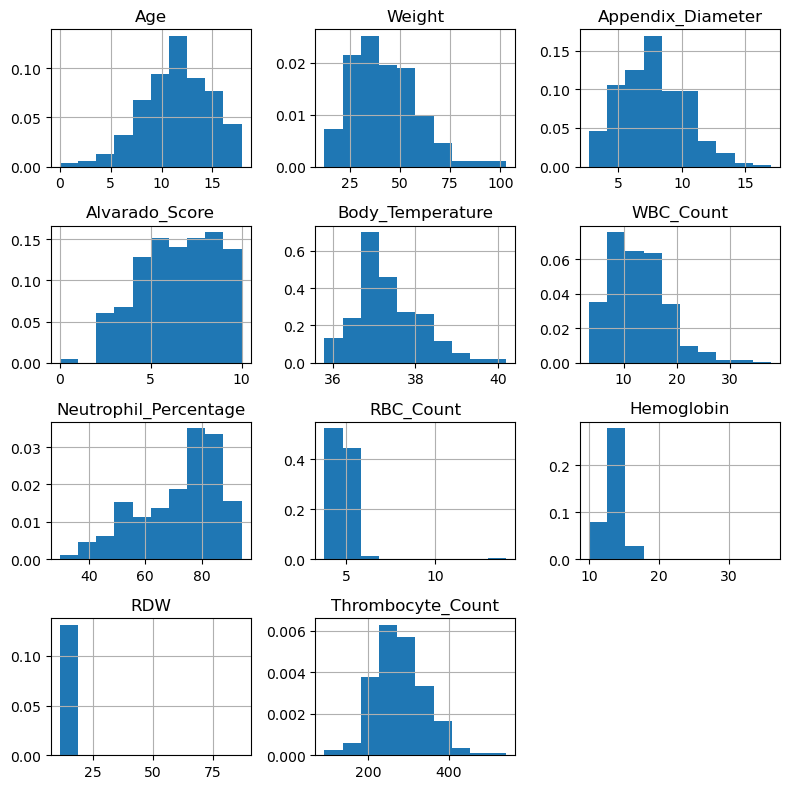

In [4]:
X = df[['Age', 'Weight', 'Appendix_Diameter', 'Alvarado_Score', 
        'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'RBC_Count',
        'Hemoglobin', 'RDW', 'Thrombocyte_Count']]

params = {'axes.titlesize':'10',
          'xtick.labelsize':'10',
          'ytick.labelsize':'10'}
# FIX plt.rcParams.update(params)
X.hist(density=True, figsize=(8,8))
#X.hist(density=True, xlabelsize=5, ylabelsize=5, figsize=(8,8))
plt.tight_layout()
# FIX plt.show()

## Removing the Outliers

In [5]:
outlierStats = df.agg( {
        "Body_Temperature": ["min", "max", "median", "mean", "std"],
        "RBC_Count":        ["min", "max", "median", "mean", "std"],
        "Hemoglobin":       ["min", "max", "median", "mean", "std"],
        "RDW":              ["min", "max", "median", "mean", "std"]
    } )
print("Outlier Statistics:", outlierStats)

def find_outliers_via_IQR(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3-q1
    outliers  =df[((df < q1 - 1.5*IQR)) | (df > (q3 + 1.5*IQR))]
    return outliers

temp_outliers = find_outliers_via_IQR(df['Body_Temperature'])
rbc_outliers = find_outliers_via_IQR(df['RBC_Count'])
hemo_outliers = find_outliers_via_IQR(df['Hemoglobin'])
rdw_outliers = find_outliers_via_IQR(df['RDW'])
outliersDF = pd.DataFrame(data = {'numOutliers': [len(temp_outliers), len(rbc_outliers), len(hemo_outliers), len(rdw_outliers)],
                                 'minVals': [temp_outliers.min(), rbc_outliers.min(), hemo_outliers.min(), rdw_outliers.min()],
                                 'maxVals': [temp_outliers.max(), rbc_outliers.max(), hemo_outliers.max(), rdw_outliers.max()]})
print("Outlier Data", outliersDF)

# Remove the outliers
bodyTemp_IQR = df.Body_Temperature.quantile(0.75) - df.Body_Temperature.quantile(0.25)
bodyTemp_LowerCutoff = df.Body_Temperature.quantile(0.25) - 2 * bodyTemp_IQR
df = df.drop(df[df.Body_Temperature < bodyTemp_LowerCutoff].index)
df = df.drop(df[df.RBC_Count > df.RBC_Count.quantile(0.75)*2].index)
df = df.drop(df[df.Hemoglobin > df.Hemoglobin.quantile(0.75)*2].index)
df = df.drop(df[df.RDW > df.RDW.quantile(0.75)*2].index)

outlierStats = df.agg( {
        "Body_Temperature": ["min", "max", "median", "mean", "std"],
        "RBC_Count":        ["min", "max", "median", "mean", "std"],
        "Hemoglobin":       ["min", "max", "median", "mean", "std"],
        "RDW":              ["min", "max", "median", "mean", "std"]
    } )
print("Updated Outlier Statistics:", outlierStats)


Outlier Statistics:         Body_Temperature  RBC_Count  Hemoglobin        RDW
min            35.800000   3.790000   10.000000  11.300000
max            40.200000  14.000000   36.000000  86.900000
median         37.200000   4.790000   13.400000  12.700000
mean           37.335431   4.830093   13.501865  13.332634
std             0.785531   0.566472    1.539009   5.960556
Outlier Data    numOutliers  minVals  maxVals
0            8    39.40     40.2
1           10     3.79     14.0
2            9    10.00     36.0
3            9    14.90     86.9
Updated Outlier Statistics:         Body_Temperature  RBC_Count  Hemoglobin        RDW
min            35.800000   3.790000   10.000000  11.300000
max            40.200000   6.000000   17.500000  18.700000
median         37.200000   4.785000   13.400000  12.700000
mean           37.337500   4.809835   13.445047  12.837736
std             0.788052   0.353249    1.092322   0.800674


## Pair Plot of Numeric Features
The following pair plot shows some correlation between age, height, and weight, and also between hemoglobin and RBC count.

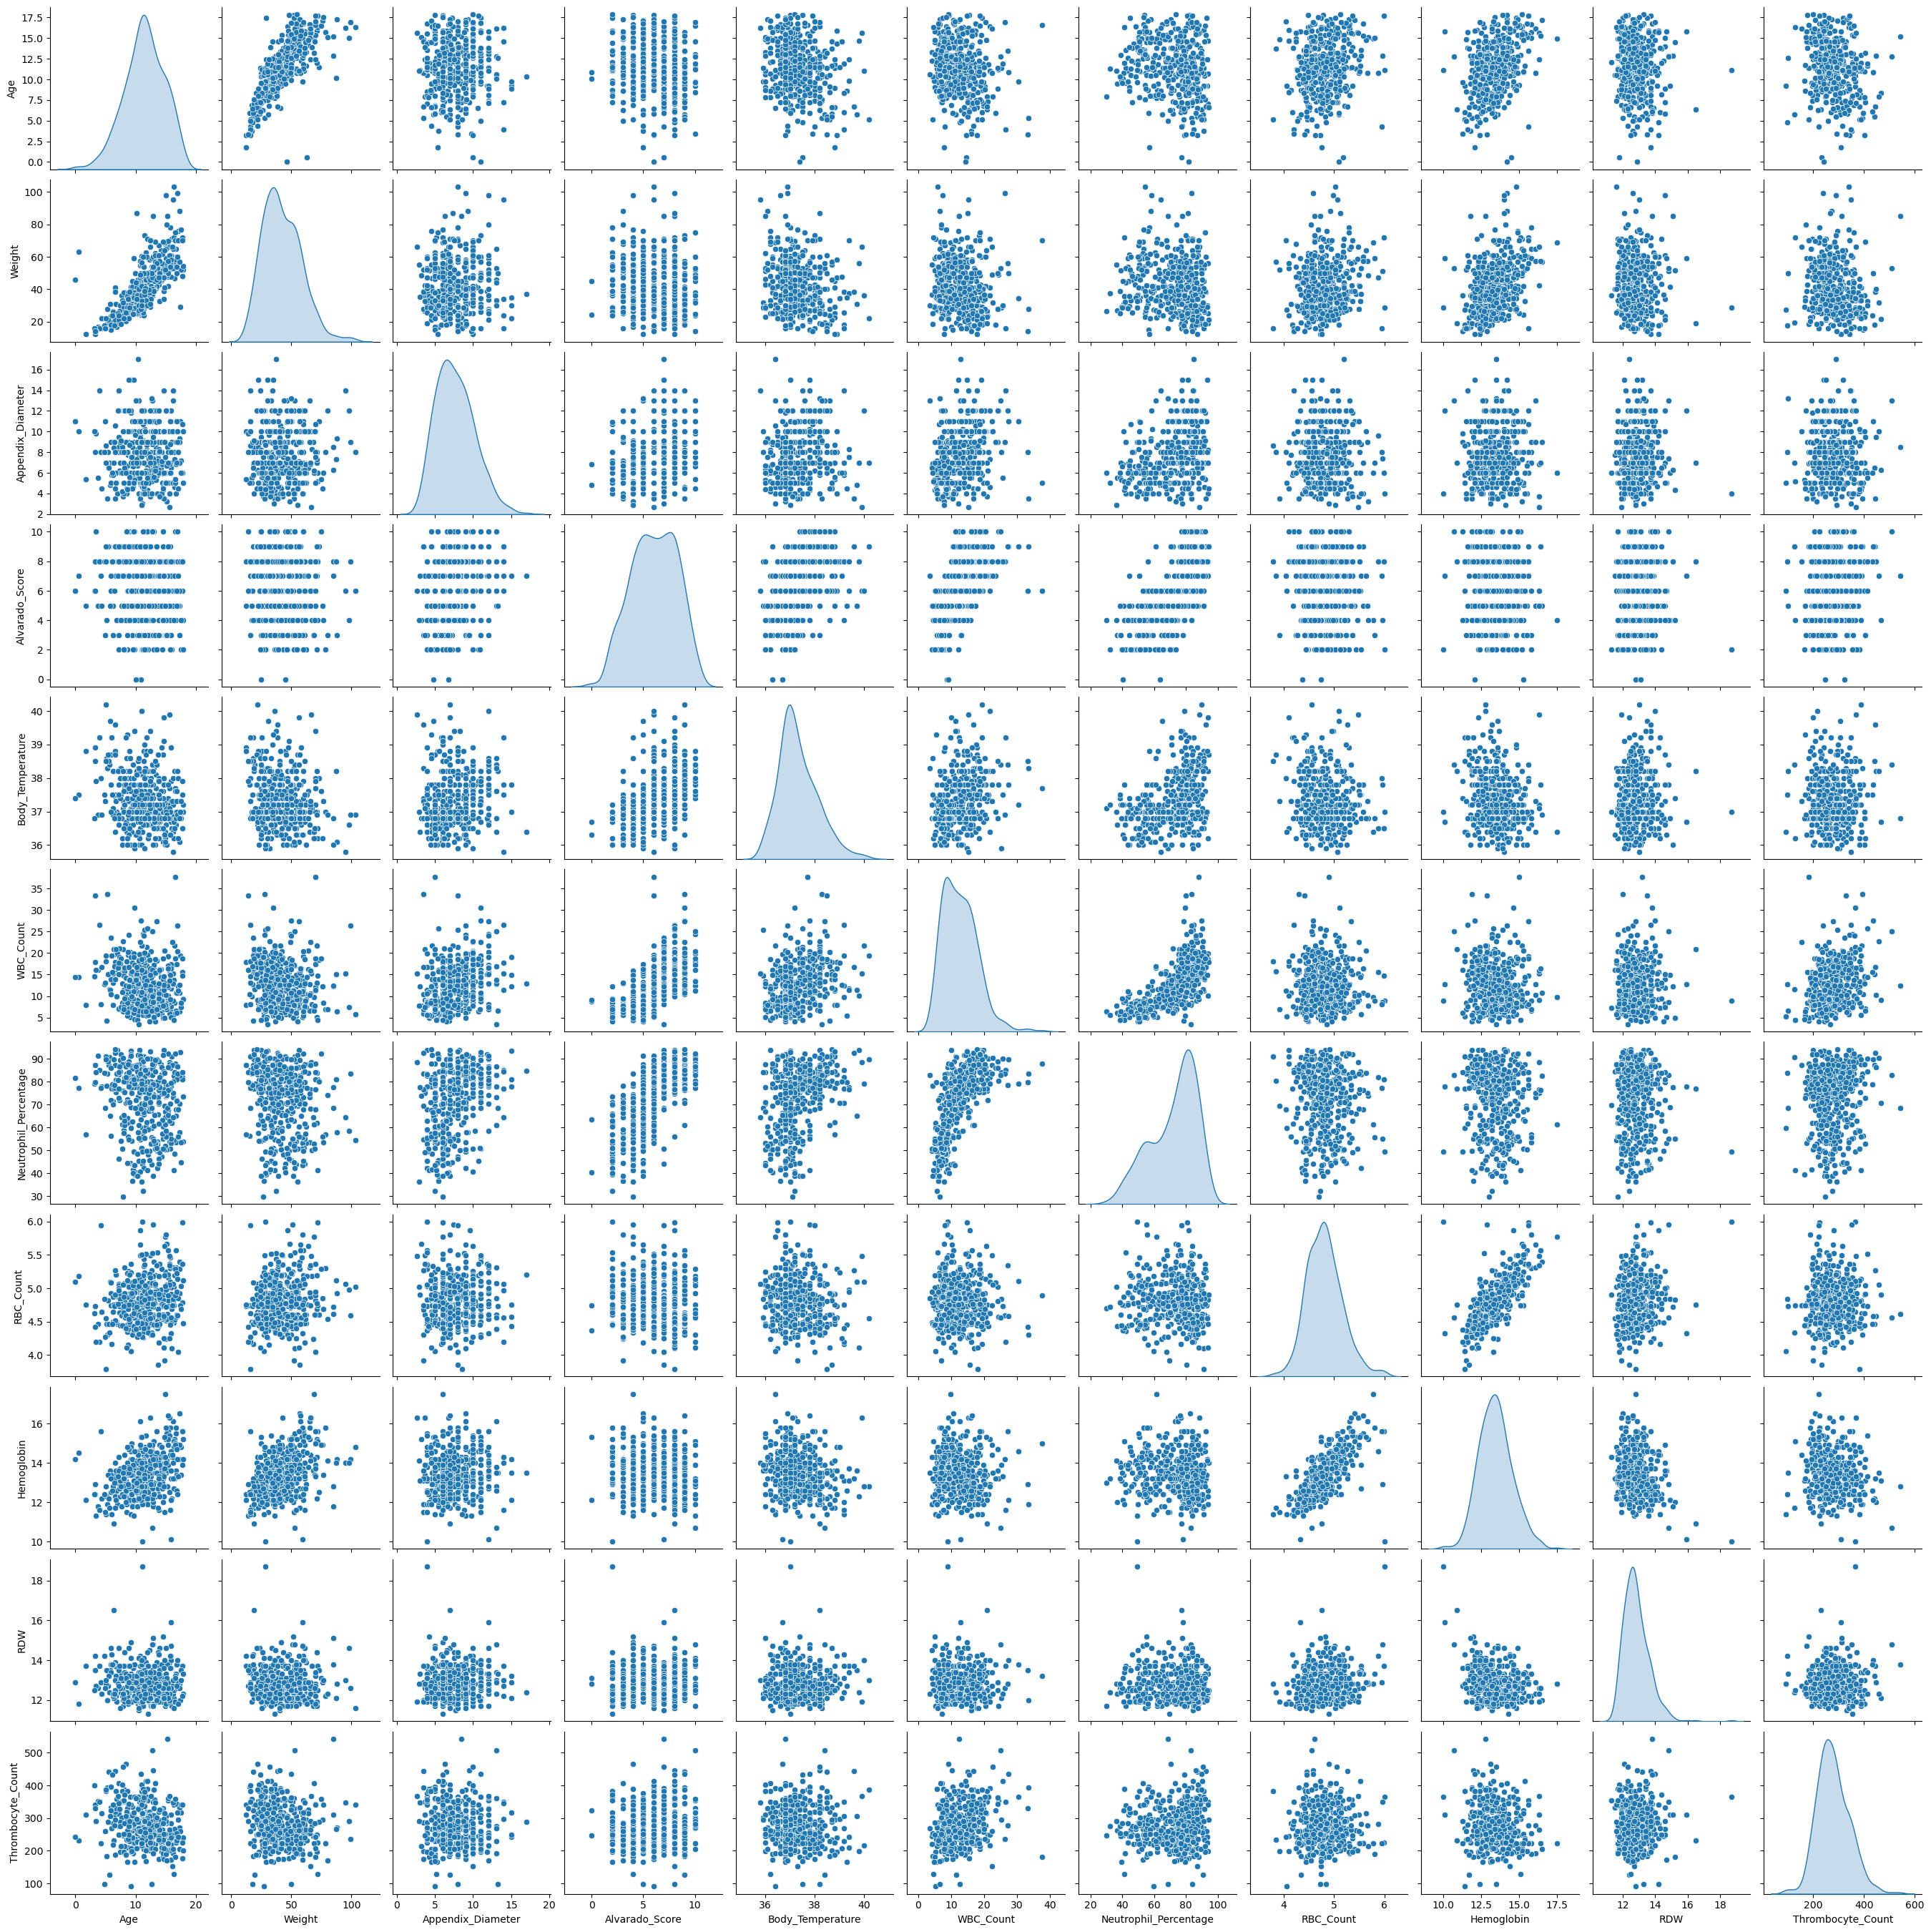

In [6]:
# X has only continuous value features
X = df[['Age', 'Weight', 'Appendix_Diameter', 'Alvarado_Score', 
        'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'RBC_Count',
        'Hemoglobin', 'RDW', 'Thrombocyte_Count']]

# Set color map to have light blue background
# FIX sns.set()
# FIX sns.set(style="white", color_codes=True, font_scale=2)
g = sns.pairplot(X, diag_kind='kde')

## Final selection of features
Based on the correlation seen in the pair plot above, the Height and Hemoglobin features are dropped.
## Splitting the data
The data was subset two ways according to the data type.  The X variable below contains only the continuous numerical fields.  The X2 variables contains the continuous numerical fields and the categorical fields.  This was done since some of the modeling techniques below don't natively handle categorical features.  The BMI field was left out since it has a direct correlation with height and weight.

In [7]:
# Capture the Diagnosis column as the target, then remove it from the data frame
diag = df['Diagnosis']
diagVal = np.where(df['Diagnosis'] == 'appendicitis', 1,-1)
print("Diagnosis values:", diag.unique())

# X has only continuous value features
X = df[['Age', 'Weight', 'Appendix_Diameter', 'Alvarado_Score', 
        'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'RBC_Count',
        'RDW', 'Thrombocyte_Count']]
Y = diagVal
# X2 has a mix of continuous value and categorical features
X2 = df[['Age', 'Weight', 'Appendix_Diameter', 'Alvarado_Score', 
         'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness',
         'Coughing_Pain', 'Nausea', 'Loss_of_Appetite',
         'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'RBC_Count',
         'RDW', 'Thrombocyte_Count']]
Y2 = diagVal
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.3)
#X_train2.info()
print("Final continuous value data dimensions:", X.shape[0], "samples, ", X.shape[1], "columns including targets")
print("Final mixed data type dimensions:", X.shape[0], "samples, ", X.shape[1], "columns including targets")
all_results = pd.DataFrame(data = {'model': ['Logistic continuous', 'Logistic mixed', 'Linear SVC', 'Non-Linear SVC', 'Gradient Boosting'],
                                    'accuracy': [0,0,0,0,0], 'precision': [0,0,0,0,0], 'F1': [0,0,0,0,0]})

Diagnosis values: ['appendicitis', 'no appendicitis']
Categories (2, object): ['appendicitis', 'no appendicitis']
Final continuous value data dimensions: 424 samples,  10 columns including targets
Final mixed data type dimensions: 424 samples,  10 columns including targets


## Logistic Regression Model
A logistic regression model was created and fitted to the continuous value features.  The model was built using the `lbfgs` solver as the `liblinear` solver did not converge.

Coefficients:                 features     coefs
0                    Age  0.079333
1                 Weight -0.012441
2      Appendix_Diameter  2.291869
3         Alvarado_Score  0.488334
4       Body_Temperature -0.220142
5              WBC_Count  0.012107
6  Neutrophil_Percentage  0.044516
7              RBC_Count -0.316826
8                    RDW  0.082173
9      Thrombocyte_Count -0.001517


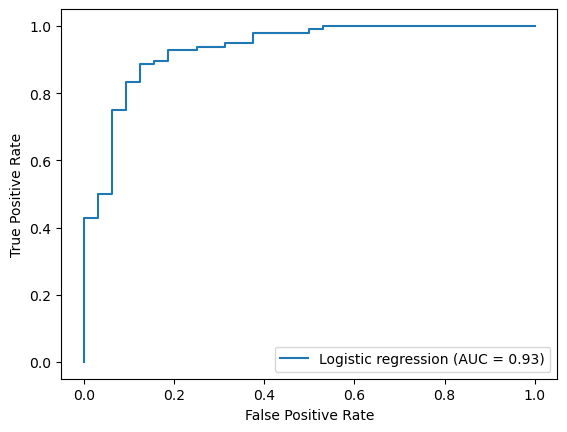

In [8]:
#%% Logistic regression of the continous value features  ---------------------
# Create an instance of Logistic Regression Classifier and fit the data.
from sklearn.linear_model import LogisticRegression
#logreg = LogisticRegression(solver='liblinear')  # liblinear solver did not converge
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)
coefs = pd.DataFrame(data = {'features':X.columns, 'coefs':list(logreg.coef_[0])})
print("Coefficients:", coefs)

# Display the ROC curve with AUC
from sklearn import metrics
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
#auc = roc_auc_score(y_test, y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)
params = {'axes.titlesize':'1',
          'xtick.labelsize':'1',
          'ytick.labelsize':'1',
          'font.size': 6}
# FIX plt.rcParams.update(params)
dispROC = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic regression')
#dispROC.figure_
#plt.xlabel('xlabel', fontsize=5)
dispROC.plot()

## Cross validation of the Logistic Regression model using the continuous value data

In [9]:
#%% Cross validation of the continuous data Logistic Regression model  --------
# Use cross validation to evaluate the logistic regression model
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X = X, y = Y, cv=5)
print("Cross Validation score mean: {:.3f} with standard deviation {:.3f}".format(np.mean(scores), np.std(scores)))

from sklearn.model_selection import cross_validate
scoring2 = ('accuracy', 'precision', 'f1')
LR_scores = cross_validate(logreg, X=X, y=Y, cv=5, scoring=scoring2)
print("Accuracy mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LR_scores['test_accuracy']), np.std(LR_scores['test_accuracy'])))
print("Precision mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LR_scores['test_precision']), np.std(LR_scores['test_precision'])))
print("F1 mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LR_scores['test_f1']), np.std(LR_scores['test_f1'])))

all_results.iloc[0,1] = np.mean(LR_scores['test_accuracy'])
all_results.iloc[0,2] = np.mean(LR_scores['test_precision'])
all_results.iloc[0,3] = np.mean(LR_scores['test_f1'])
#print("All results:")
#print(all_results)

Cross Validation score mean: 0.913 with standard deviation 0.010
Accuracy mean: 0.913 with standard deviation 0.010
Precision mean: 0.944 with standard deviation 0.027
F1 mean: 0.941 with standard deviation 0.006


## One Hot Encoding and Pipeline for Logistic Regression
In order to incorporate the categorical data in the dataset, a new technique was used that wasn't covered in the class materials.  The categorical data needed to be converted to dummy variables and this was done using the `OneHotEncoder` from `sklearn`.

In [10]:
#%% Logistic regression of the mixed data type features  ---------------------
# First, have to set up One Hot encoding  -------------------------------------------
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

LR_one_hot = make_pipeline(
    one_hot_encoder, LogisticRegression(solver='lbfgs', max_iter=5000)
)

LR_mixed_scores = cross_validate(LR_one_hot, X = X2, y = Y2, cv = 5, scoring = scoring2)
print("Accuracy mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LR_mixed_scores['test_accuracy']), np.std(LR_mixed_scores['test_accuracy'])))
print("Precision mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LR_mixed_scores['test_precision']), np.std(LR_mixed_scores['test_precision'])))
print("F1 mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LR_mixed_scores['test_f1']), np.std(LR_mixed_scores['test_f1'])))
all_results.iloc[1,1] = np.mean(LR_mixed_scores['test_accuracy'])
all_results.iloc[1,2] = np.mean(LR_mixed_scores['test_precision'])
all_results.iloc[1,3] = np.mean(LR_mixed_scores['test_f1'])
#print("All results:")
#print(all_results)

Accuracy mean: 0.908 with standard deviation 0.014
Precision mean: 0.932 with standard deviation 0.017
F1 mean: 0.939 with standard deviation 0.010


## Linear SVC model
Next, a linear SVC model was created and fitted.

In [11]:
#%% Create a Linear SVM model -----------------------------------------------
from sklearn.svm import LinearSVC

# Build a LinearSVC model called lsvm.
#df_basics.drop('Diagnosis', axis=1, inplace=True)
#df_basics.drop('Sex', axis=1, inplace=True)
lsvm = LinearSVC(dual='auto', C = 1, loss = 'squared_hinge', max_iter=5000).fit(X_train, y_train)

scores = cross_val_score(lsvm, X = X, y = diagVal, cv=5)
print("Cross Validation score mean: {:.3f} with standard deviation {:.3f}".format(np.mean(scores), np.std(scores)))


Cross Validation score mean: 0.920 with standard deviation 0.016


In [12]:
#%% Use Grid Search on the LInear SVC model with only continuous value features
from sklearn.model_selection import cross_val_score, GridSearchCV
C_vals = np.array([0.5, 1, 2, 3])
param_grid = {'C': C_vals}
grid = GridSearchCV(lsvm, param_grid = param_grid, cv=5)
grid.fit(X, Y)
# scores = cross_val_score(grid, X, y = y)
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]
print("Max mean_test_score:", np.max(results_df["mean_test_score"]))

sorted(grid.cv_results_.keys())
print("Best parameters:", grid.best_params_)
print("Best accuracy score:", grid.best_score_)

Max mean_test_score: 0.9198039215686276
Best parameters: {'C': 0.5}
Best accuracy score: 0.9198039215686276


In [13]:
# Create a Linear SVC model based on the learning from the GridSearch above and record the performance
lsvm = LinearSVC(dual='auto', C = 0.5, loss = 'squared_hinge', max_iter=5000).fit(X_train, y_train)
LSVC_scores = cross_validate(lsvm, X = X, y = Y, cv = 5, scoring = scoring2)
print("Accuracy mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LSVC_scores['test_accuracy']), np.std(LSVC_scores['test_accuracy'])))
print("Precision mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LSVC_scores['test_precision']), np.std(LSVC_scores['test_precision'])))
print("F1 mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(LSVC_scores['test_f1']), np.std(LSVC_scores['test_f1'])))
all_results.iloc[2,1] = np.mean(LSVC_scores['test_accuracy'])
all_results.iloc[2,2] = np.mean(LSVC_scores['test_precision'])
all_results.iloc[2,3] = np.mean(LSVC_scores['test_f1'])
#print("All results:")
#print(all_results)

Accuracy mean: 0.920 with standard deviation 0.016
Precision mean: 0.953 with standard deviation 0.021
F1 mean: 0.945 with standard deviation 0.012


## Non-Linear SVC
Next, a Non-Linear SVC was created and fitted while incorporating the categorical data using the `OneHotEncoder`.

In [14]:
#%% Non-linear SVM
from sklearn.svm import SVC
nlsvm = SVC(C = 0.5, gamma = 0.5, kernel = 'rbf')
nlsvm.fit(X, Y)
scores = cross_val_score(nlsvm, X, y = Y)
print("cross-val mean-accuracy (C=0.5, gamma=0.5): {:.3f}".format(np.mean(scores)))

NLSVC_one_hot = make_pipeline(
    one_hot_encoder, SVC(C = 0.5, gamma = 0.5, kernel = 'rbf')
)

NLSVC_mixed_scores = cross_validate(NLSVC_one_hot, X = X2, y = Y2, cv = 5, scoring = scoring2)
print("Accuracy mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(NLSVC_mixed_scores['test_accuracy']), np.std(NLSVC_mixed_scores['test_accuracy'])))
print("Precision mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(NLSVC_mixed_scores['test_precision']), np.std(NLSVC_mixed_scores['test_precision'])))
print("F1 mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(NLSVC_mixed_scores['test_f1']), np.std(NLSVC_mixed_scores['test_f1'])))
all_results.iloc[3,1] = np.mean(NLSVC_mixed_scores['test_accuracy'])
all_results.iloc[3,2] = np.mean(NLSVC_mixed_scores['test_precision'])
all_results.iloc[3,3] = np.mean(NLSVC_mixed_scores['test_f1'])
print("All results:")
print(all_results)

cross-val mean-accuracy (C=0.5, gamma=0.5): 0.743
Accuracy mean: 0.743 with standard deviation 0.004
Precision mean: 0.743 with standard deviation 0.004
F1 mean: 0.853 with standard deviation 0.002
All results:
                 model  accuracy  precision        F1
0  Logistic continuous  0.912717   0.944139  0.941158
1       Logistic mixed  0.908039   0.931789  0.938508
2           Linear SVC  0.919804   0.952845  0.945446
3       Non-Linear SVC  0.742941   0.742941  0.852510
4    Gradient Boosting  0.000000   0.000000  0.000000


## Pipelining GridSearch on the Non-Linear SVC
In order to optimize the Non-Linear SVC, the GridSearchCV was used.  However, in order to use the categorical data, it needed to be transformed using a pipeline method.  This turned out to be quite tricky and the `param_grid = dict(clf__C = C_vals, clf__gamma = gamma_vals)` line below was key.  Using the key name `clf__C` allowed the parameter array to be fed to the GridSearch through the pipeline.

In [15]:
#%% Pipeline for non-linear SVC with GridSearch
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
categorical_encoder = preprocessing.OneHotEncoder()

from sklearn.compose import make_column_selector
the_preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, make_column_selector(dtype_include='category')),
     ('num', 'passthrough', make_column_selector(dtype_exclude='category'))])

pipe = Pipeline([
    ('preprocess', the_preprocessing),
    ('clf', SVC())
])

C_vals = np.array([0.5, 1, 2, 3])
gamma_vals = np.array([0.5, 1, 2, 3])
param_grid = dict(clf__C = C_vals, clf__gamma = gamma_vals)
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)
grid.fit(X2, Y2)

results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]
print("Max mean_test_score:", np.max(results_df["mean_test_score"]))

sorted(grid.cv_results_.keys())
print("Best parameters:", grid.best_params_)
print("Best accuracy score:", grid.best_score_)

#pipe2 = Pipeline([
#    ('preprocess', the_preprocessing),
#    ('clf', SVC(C=0.5, gamma=0.5))
#])
#pipe2.fit(X_train2, y_train2)
#from sklearn.inspection import permutation_importance
#result = permutation_importance(pipe2, X_test2, y_test2, n_repeats=10, n_jobs=2)
#print(result)
# make list of feature importances for each output
#gb_feat_impts = [clf.feature_importances_ for clf in grid.best_estimator_._final_estimator.estimators_]

# calculate mean feature importance from all outputs of multioutputclassifier
#gb_impts_means = np.mean(gb_feat_impts, axis = 0)

# zip together column names with feature importances, sort by importance
#gb_means_names = sorted(zip(X2.columns, gb_impts_means), key = lambda x: x[1], reverse=True)

Max mean_test_score: 0.7429411764705882
Best parameters: {'clf__C': 0.5, 'clf__gamma': 0.5}
Best accuracy score: 0.7429411764705882


## Gradient Boosting
The final model created and fitted was a Histogram Gradient Boosting Classifier.

In [16]:
#%% Gradient Boosting -----------------------------------------------------
from sklearn.ensemble import HistGradientBoostingClassifier
hist_one_hot = make_pipeline(
    one_hot_encoder, HistGradientBoostingClassifier(max_iter=400, max_depth=2)
)
scoring = 'accuracy'
scores = cross_val_score(hist_one_hot, X = X2, y = Y2, cv=5, scoring=scoring)
print("Cross Validation score mean: {:.3f} with standard deviation {:.3f}".format(np.mean(scores), np.std(scores)))

from sklearn.model_selection import cross_validate
scoring2 = ('accuracy', 'precision', 'f1')
scores2 = cross_validate(hist_one_hot, X=X2, y=Y2, cv=5, scoring=scoring2)
print("Accuracy mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(scores2['test_accuracy']), np.std(scores2['test_accuracy'])))
print("Precision mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(scores2['test_precision']), np.std(scores2['test_precision'])))
print("F1 mean: {:.3f} with standard deviation {:.3f}"
      .format(np.mean(scores2['test_f1']), np.std(scores2['test_f1'])))
all_results.iloc[4,1] = np.mean(scores2['test_accuracy'])
all_results.iloc[4,2] = np.mean(scores2['test_precision'])
all_results.iloc[4,3] = np.mean(scores2['test_f1'])

Cross Validation score mean: 0.967 with standard deviation 0.017
Accuracy mean: 0.967 with standard deviation 0.017
Precision mean: 0.984 with standard deviation 0.010
F1 mean: 0.977 with standard deviation 0.012


## Conclusion
The Gradient Boosting model had the strongest performance and the Non-Linear SVC model had the worst performance.  The non-linear SVC is most likely overfitting the training data.lds.

In [17]:
print("All results:")
print(all_results)

All results:
                 model  accuracy  precision        F1
0  Logistic continuous  0.912717   0.944139  0.941158
1       Logistic mixed  0.908039   0.931789  0.938508
2           Linear SVC  0.919804   0.952845  0.945446
3       Non-Linear SVC  0.742941   0.742941  0.852510
4    Gradient Boosting  0.966947   0.984122  0.977492


## Further work
Possible further work on this project could include targeting the management (surgical vs. conservative) and severity (complicated vs. uncomplicated or no appendicitis) fields to determine if they can be predicted.